# Time Series Analysis for GSK, Pfizer and AstraZeneca using ARIMA

In [1]:
# Project 2      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb
from statsmodels.tsa.arima_model import ARIMA

## Splitting the data into individual datasets

In [2]:
# Load the closing prices 
df = pd.read_csv(Path('../Data/df.csv')).drop([1])
# df1 = pd.read_csv(Path('../Data/df.csv')).drop([0,1])
df.tail(3)

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
692,2020-09-29,2868200.0,12820200.0,4177500.0,37.43000030517578,36.16999816894531,55.11000061035156
693,2020-09-30,3739700.0,21464600.0,2982200.0,37.63999938964844,36.70000076293945,54.79999923706055
694,2020-10-01,3870294.0,20533171.0,4718982.0,37.13999938964844,36.369998931884766,54.29999923706055


In [4]:
def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close],
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2018-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df

In [5]:
# extract data for GSK and create a dataframe for GSK/Pfizer, AZ
gsk_df = construct_df(df, "Volume","Adj Close")
pfe_df = construct_df(df, "Volume.1","Adj Close.1")
azn_df = construct_df(df, "Volume.2","Adj Close.2")
# Data Checks
gsk_df.tail(2), gsk_df.dtypes, pfe_df.head(2), pfe_df.dtypes, azn_df.head(2), azn_df.dtypes

(               Volume  Adj Close
 Date                            
 2020-09-30  3739700.0  37.639999
 2020-10-01  3870294.0  37.139999,
 Volume       float64
 Adj Close    float64
 dtype: object,
                 Volume  Adj Close
 Date                             
 2018-01-02  16185800.0  32.927341
 2018-01-03  13456500.0  33.171303,
 Volume       float64
 Adj Close    float64
 dtype: object,
                Volume  Adj Close
 Date                            
 2018-01-02  6107400.0  31.993856
 2018-01-03  4195400.0  32.057152,
 Volume       float64
 Adj Close    float64
 dtype: object)

## Creating Training and validation Dataset

In [6]:
# Trim the datasets to have Training data until 9 July 2020 (70%: 30% split)
gsk_df_tr = gsk_df.loc['2018-1-1':'2020-7-09']
pfe_df_tr = pfe_df.loc['2018-1-1':'2020-7-09']
azn_df_tr = azn_df.loc['2018-1-1':'2020-7-09']

# Trim the datasets to have Validation data from 10 July 2020 - 30 Sep 2020 (70%: 30% split)
gsk_df_val = gsk_df.loc['2020-07-10':'2020-09-30']
pfe_df_val = pfe_df.loc['2020-07-10':'2020-09-30']
azn_df_val = azn_df.loc['2020-07-10':'2020-09-30']

# Data Checks
gsk_df_tr.head(), pfe_df_tr.tail(), azn_df_tr.tail(), gsk_df_val.tail()

(               Volume  Adj Close
 Date                            
 2018-01-02  9465500.0  32.100533
 2018-01-03  6600800.0  31.978849
 2018-01-04  5206400.0  32.039688
 2018-01-05  7250700.0  32.604683
 2018-01-08  5909100.0  32.509071,
                 Volume  Adj Close
 Date                             
 2020-07-02  42951500.0  34.175972
 2020-07-06  25759900.0  34.175972
 2020-07-07  23859600.0  33.700619
 2020-07-08  23013800.0  33.423332
 2020-07-09  19320400.0  33.136139,
                Volume  Adj Close
 Date                            
 2020-07-02  4591300.0  53.373314
 2020-07-06  5180900.0  53.670937
 2020-07-07  3747500.0  53.045933
 2020-07-08  6247800.0  53.760220
 2020-07-09  4203000.0  53.541969,
                Volume  Adj Close
 Date                            
 2020-09-24  3502900.0  37.380001
 2020-09-25  3275200.0  37.799999
 2020-09-28  3012800.0  37.860001
 2020-09-29  2868200.0  37.430000
 2020-09-30  3739700.0  37.639999)

## Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the closing price into a trend and noise.

In [7]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Adj Close" into two separate series:
ts_noise_gsk, ts_trend_gsk = sm.tsa.filters.hpfilter(gsk_df_tr["Adj Close"])
ts_noise_pfe, ts_trend_pfe = sm.tsa.filters.hpfilter(pfe_df_tr["Adj Close"])
ts_noise_azn, ts_trend_azn = sm.tsa.filters.hpfilter(azn_df_tr["Adj Close"])

In [8]:
# Create dataframes of just the exchange rate price, and add columns for "noise" and "trend" series from above:
gsk_df_tr["ts_noise_gsk"] = ts_noise_gsk
gsk_df_tr["ts_trend_gsk"] = ts_trend_gsk

pfe_df_tr["ts_noise_pfe"] = ts_noise_pfe
pfe_df_tr["ts_trend_pfe"] = ts_trend_pfe

azn_df_tr["ts_noise_azn"] = ts_noise_azn
azn_df_tr["ts_trend_azn"] = ts_trend_azn

gsk_df_tr.reset_index()
pfe_df_tr.reset_index()
azn_df_tr.reset_index()

gsk_df_hpf = gsk_df_tr[["Adj Close", "ts_noise_gsk", "ts_trend_gsk"]]
pfe_df_hpf = pfe_df_tr[["Adj Close", "ts_noise_pfe", "ts_trend_pfe"]]
azn_df_hpf = azn_df_tr[["Adj Close", "ts_noise_azn", "ts_trend_azn"]]
# Data Sample Checks
gsk_df_hpf.tail(), pfe_df_hpf.tail(), azn_df_hpf.tail()

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

(            Adj Close  ts_noise_gsk  ts_trend_gsk
 Date                                             
 2020-07-02  40.739948      0.434126     40.305822
 2020-07-06  40.532391      0.270430     40.261961
 2020-07-07  39.909733     -0.307850     40.217583
 2020-07-08  40.255653      0.082683     40.172971
 2020-07-09  39.899845     -0.228371     40.128216,
             Adj Close  ts_noise_pfe  ts_trend_pfe
 Date                                             
 2020-07-02  34.175972      1.324511     32.851461
 2020-07-06  34.175972      1.330408     32.845564
 2020-07-07  33.700619      0.859120     32.841499
 2020-07-08  33.423332      0.585156     32.838177
 2020-07-09  33.136139      0.301097     32.835042,
             Adj Close  ts_noise_azn  ts_trend_azn
 Date                                             
 2020-07-02  53.373314      0.394014     52.979300
 2020-07-06  53.670937      0.641027     53.029910
 2020-07-07  53.045933     -0.036009     53.081942
 2020-07-08  53.760220      0

In [9]:
# Data Checks
gsk_df_hpf.dtypes, pfe_df_hpf.dtypes, azn_df_hpf.dtypes

(Adj Close       float64
 ts_noise_gsk    float64
 ts_trend_gsk    float64
 dtype: object,
 Adj Close       float64
 ts_noise_pfe    float64
 ts_trend_pfe    float64
 dtype: object,
 Adj Close       float64
 ts_noise_azn    float64
 ts_trend_azn    float64
 dtype: object)

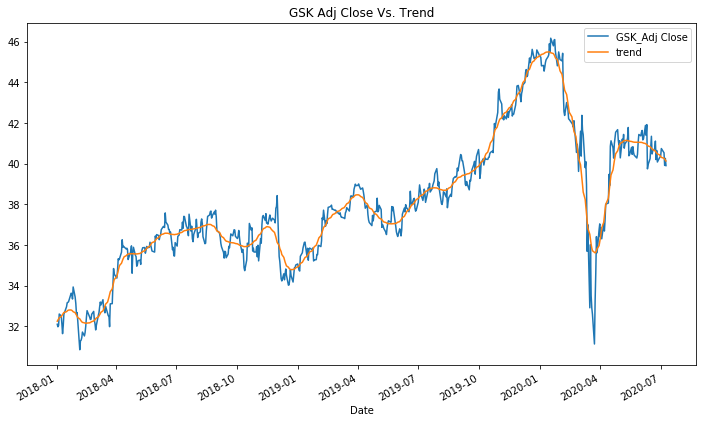

In [10]:
# Plot the GSK_Adj Close vs. the Trend from Jan to June 2020
gsk_df_hpf["Adj Close"].plot(label = 'GSK_Adj Close', figsize=(10,6),legend = True)
gsk_df_hpf.ts_trend_gsk.plot(label = 'trend', title='GSK Adj Close Vs. Trend', figsize=(12,7),legend = True);

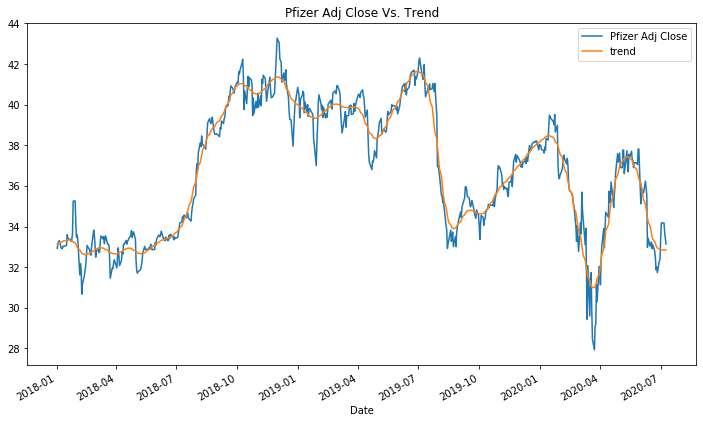

In [11]:
# Plot the PFE_Adj Close vs. the Trend from Jan to June 2020
pfe_df_hpf["Adj Close"].plot(label = 'Pfizer Adj Close', figsize=(10,6),legend = True)
pfe_df_hpf.ts_trend_pfe.plot(label = 'trend', title='Pfizer Adj Close Vs. Trend', figsize=(12,7),legend = True);

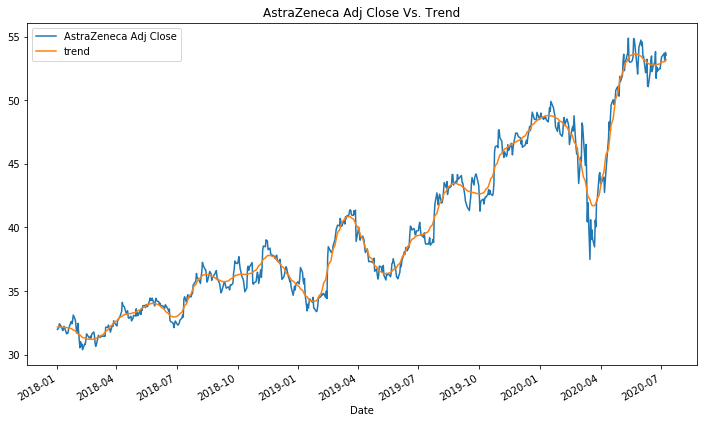

In [12]:
# Plot the AstraZenca Adj Close vs. the Trend from Jan to June 2020
azn_df_hpf["Adj Close"].plot(label = 'AstraZeneca Adj Close', figsize=(10,6),legend = True)
azn_df_hpf.ts_trend_azn.plot(label = 'trend', title='AstraZeneca Adj Close Vs. Trend', figsize=(12,7),legend = True);

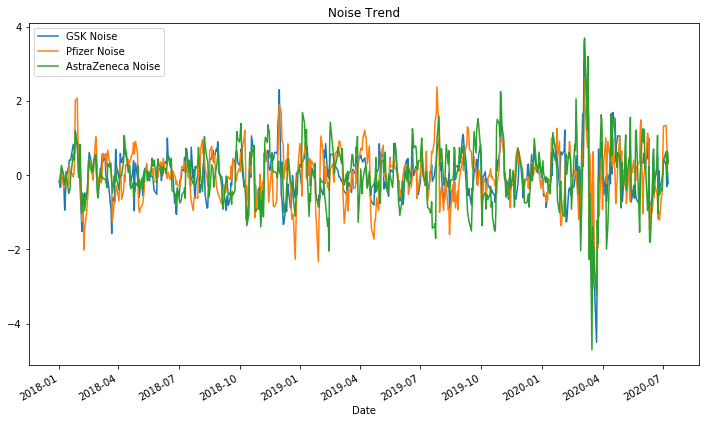

In [13]:
# Plot the GSK/Pfizer/AstraZeneca Price Noise
gsk_df_hpf.ts_noise_gsk.plot(label = 'GSK Noise', figsize=(12,7), legend = True);
pfe_df_hpf.ts_noise_pfe.plot(label = 'Pfizer Noise', figsize=(12,7), legend = True);
azn_df_hpf.ts_noise_azn.plot(label = 'AstraZeneca Noise', title='Noise Trend', figsize=(12,7), legend = True);

## Autocorrelation & Partial Autocorrelation Analysis

Use the autocorrelation and partial autocorrelation data to get a sense of how many lags to use in the ARMA/ARIMA/GARCH models

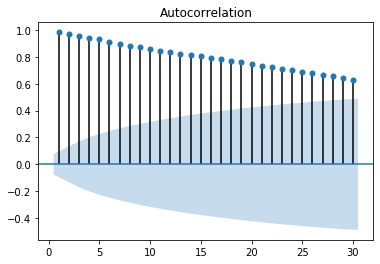

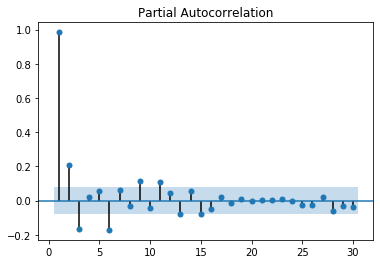

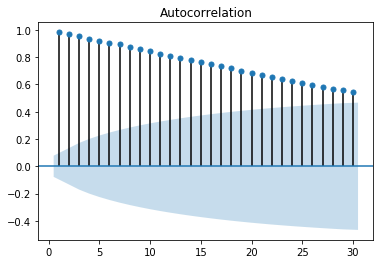

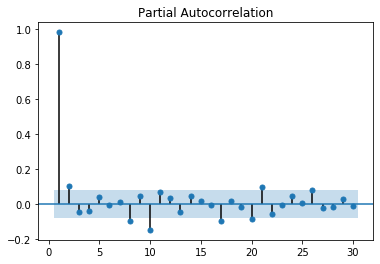

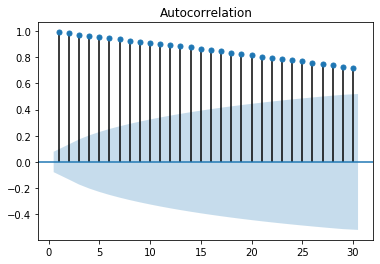

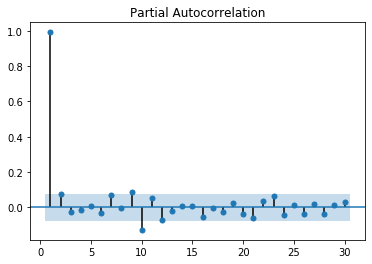

In [14]:
# Import ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(gsk_df_tr['Adj Close'], lags=30, zero=False)
plot_pacf(gsk_df_tr['Adj Close'], lags=30, zero=False);

plot_acf(pfe_df_tr['Adj Close'], lags=30, zero=False)
plot_pacf(pfe_df_tr['Adj Close'], lags=30, zero=False);

plot_acf(azn_df_tr['Adj Close'], lags=30, zero=False)
plot_pacf(azn_df_tr['Adj Close'], lags=30, zero=False);

ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Basically, how well the present value of the series is related to its past values. While, PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.

Both ACF and PACF can be used to identify the orders of AR and MA terms in the ARMA model.

From the above ACF plot we notice that 8-10 lags could potentialy useful while PACF is significant at the 5-7 lags are outside the default confidence interval of 95%. Hence, we will play with p and q accordingly to create the ARIMA models for each of the pharmaceutical stocks.

## Variable Selection for the ARIMA Model

Comparing Absolute Adj returns versus percent change metrics to conclude which variable is better fit for model development 

In [15]:
# Creating percent change of the Adj Close 
GSK_returns = (gsk_df_tr[['Adj Close']].pct_change()).replace(-np.inf, np.nan).dropna()
PFE_returns = (pfe_df_tr[['Adj Close']].pct_change()).replace(-np.inf, np.nan).dropna()
AZN_returns = (azn_df_tr[['Adj Close']].pct_change()).replace(-np.inf, np.nan).dropna()
GSK_returns.tail(2), PFE_returns.tail(2), AZN_returns.tail(2)

(            Adj Close
 Date                 
 2020-07-08   0.008668
 2020-07-09  -0.008839,
             Adj Close
 Date                 
 2020-07-08  -0.008228
 2020-07-09  -0.008593,
             Adj Close
 Date                 
 2020-07-08   0.013465
 2020-07-09  -0.004060)

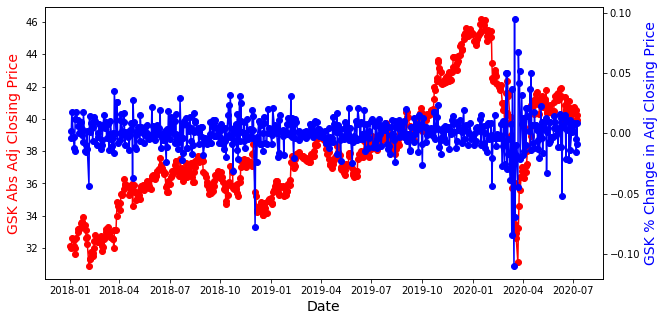

In [16]:
# Plotting the Absolute GSK Adj Closing price versus % change in the Adj Closing price to determine which data should be used in
# modelling exercise

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize= (10,5))
# make a plot
ax.plot(gsk_df_tr.index, gsk_df_tr['Adj Close'], color="red", marker="o")
# # set x-axis label
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("GSK Abs Adj Closing Price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(GSK_returns.index, GSK_returns['Adj Close'],color="blue",marker="o")
ax2.set_ylabel("GSK % Change in Adj Closing Price",color="blue",fontsize=14)
plt.show()

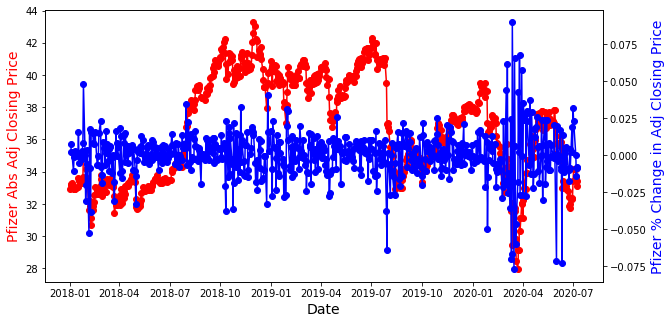

In [17]:
# Plotting the Absolute Pfizer Adj Closing price versus % change in the Adj Closing price to determine which data should be used in
# modelling exercise
fig,ax = plt.subplots(figsize= (10,5))
ax.plot(pfe_df_tr.index, pfe_df_tr['Adj Close'], color="red", marker="o")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Pfizer Abs Adj Closing Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(PFE_returns.index, PFE_returns['Adj Close'],color="blue",marker="o")
ax2.set_ylabel("Pfizer % Change in Adj Closing Price",color="blue",fontsize=14)
plt.show()

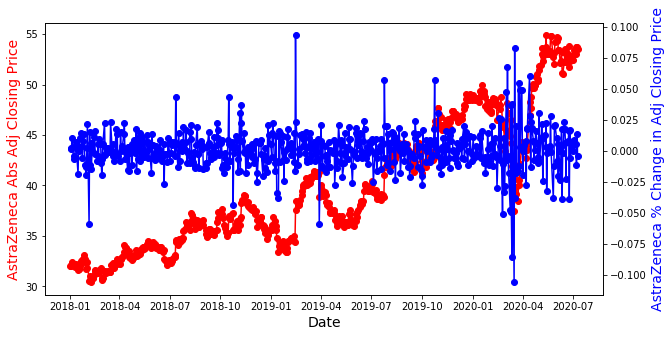

In [18]:
# Plotting the Absolute AstraZeneca Adj Closing price versus % change in the Adj Closing price to determine which data should be used in
# modelling exercise
fig,ax = plt.subplots(figsize= (10,5))
ax.plot(azn_df_tr.index, azn_df_tr['Adj Close'], color="red", marker="o")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("AstraZeneca Abs Adj Closing Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(AZN_returns.index, AZN_returns['Adj Close'],color="blue",marker="o")
ax2.set_ylabel("AstraZeneca % Change in Adj Closing Price",color="blue",fontsize=14)
plt.show()

From the above graphs it is evident that % change in the adjusted closing prices is more stationary than the absolute adjusted closing price and hence, should be used in ARIMA modelling

## Forecasting GSK Returns using an ARIMA Model

 1. Using the *percent change* of the GSK Adj Close, estimate an ARIMA model.
     1. Set P=8, D=1, and Q=7 in the model (e.g., ARIMA(df, order=(8,1,7))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 3 months forecast for the GSK 'Adj Close'. What does the model forecast will happen to the Japanese Yen in the near term?

In [19]:
# Estimate ARIMA Model:
model = ARIMA(GSK_returns['Adj Close'], order=(2, 1, 1))
# Fit the model
results = model.fit()
# save model
results.save("../Model Results/GSK_ARIMA_PC_model.pkl")

from statsmodels.tsa.arima_model import ARIMAResults
# load model
loaded = ARIMAResults.load("../Model Results/GSK_ARIMA_PC_model.pkl")
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  632
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1800.986
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 01 Oct 2020   AIC                          -3591.972
Time:                        18:55:27   BIC                          -3569.728
Sample:                             1   HQIC                         -3583.333
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.317e-06   2.93e-06     -0.449      0.653   -7.06e-06    4.43e-06
ar.L1.D.Adj Close    -0.2051      0.039     -5.232      0.000      -0.282      -0.128
ar.L2.D.Adj Close     0.1715      0.039      4.376      0.000       0.095       0.248
ma.L1.D.Adj Close    -0.9999      0.004   -240.606      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8896           +0.0000j            1.8896            0.5000
AR.2            3.0855           +0.0000j            3.0855            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
# #Getting the forecasted values of the adjusted closing price
gsk_forecasted_values=np.array(1+ results.forecast(steps=58)[0])
for i in range(1, len(gsk_forecasted_values)):
    gsk_forecasted_values[i] = gsk_forecasted_values[i]*gsk_forecasted_values[i-1]
gsk_forecasted_values = gsk_forecasted_values*gsk_df.loc['2020-07-09']['Adj Close']
gsk_forecasted_values

array([40.03327219, 39.94684403, 39.98911018, 39.96723509, 39.98052885,
       39.97555211, 39.98030096, 39.97986647, 39.98210906, 39.98285903,
       39.98431998, 39.98532468, 39.98649052, 39.98749065, 39.988498  ,
       39.98942105, 39.99030821, 39.99113386, 39.99191155, 39.9926341 ,
       39.99330532, 39.99392318, 39.99448875, 39.99500145, 39.9954616 ,
       39.99586903, 39.99622381, 39.99652591, 39.99677535, 39.99697211,
       39.9971162 , 39.99720761, 39.99724635, 39.99723242, 39.99716581,
       39.99704652, 39.99687456, 39.99664993, 39.99637263, 39.99604265,
       39.99566   , 39.99522469, 39.9947367 , 39.99419605, 39.99360274,
       39.99295677, 39.99225814, 39.99150685, 39.99070291, 39.98984632,
       39.98893708, 39.9879752 , 39.98696068, 39.98589352, 39.98477373,
       39.98360132, 39.98237628, 39.98109863])

## Validation of the GSK

In [21]:
# Getting the array of the actual adjusted closing prices for GSK stock
gsk_actual_val = np.array(gsk_df_val["Adj Close"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(gsk_actual_val) - np.array(gsk_forecasted_values))
GSK_avg_error = sum(abs_change)/ len(abs_change)
# Printing the average error term
print(GSK_avg_error)

0.8886263801022687


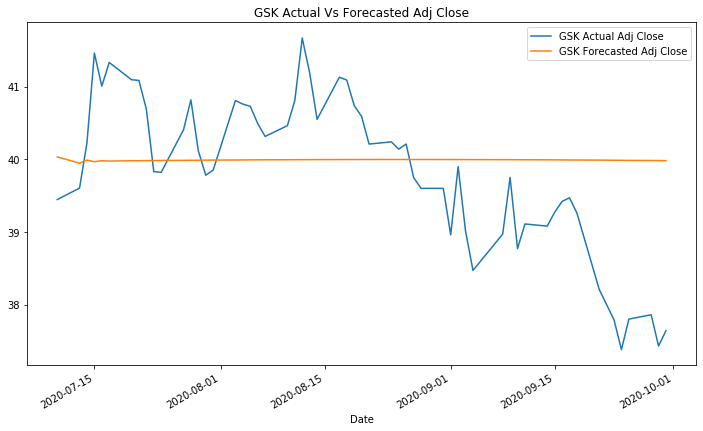

In [22]:
# Combining Date,Actual and Predicted Adj Closing price for GSK 
GSK_Comp1 = pd.DataFrame({'Date': gsk_df_val.index.values, 'GSK_Actual_Adj_Close': gsk_actual_val, 'GSK_Forecasted_Adj_Close': gsk_forecasted_values}, columns=['Date', 'GSK_Actual_Adj_Close', 'GSK_Forecasted_Adj_Close'])
GSK_Comp= GSK_Comp1.set_index("Date")
# Plot the variation of model
GSK_Comp["GSK_Actual_Adj_Close"].plot(label = 'GSK Actual Adj Close', figsize=(10,6),legend = True)
GSK_Comp["GSK_Forecasted_Adj_Close"].plot(label = 'GSK Forecasted Adj Close', title='GSK Actual Vs Forecasted Adj Close', figsize=(12,7),legend = True);
plt.savefig("../Images/TS_GSK_Actual_Forecasted.png")

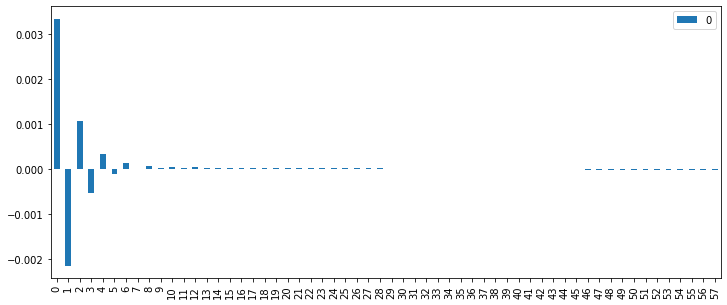

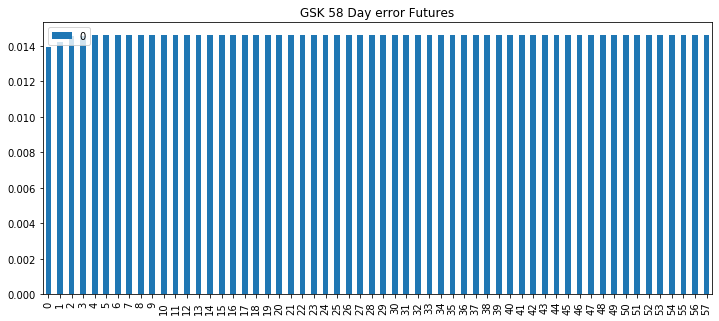

In [23]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=58)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=58)[1]).plot(kind='bar',title="GSK 58 Day error Futures",figsize=(12,5),legend = True);

# Forecasting PFizer Returns using an ARIMA Model

In [24]:
model = ARIMA(PFE_returns['Adj Close'], order=(2, 1, 1))
# Fit the model
results = model.fit()
# save model
results.save("../Model Results/PFE_ARIMA_PC_model.pkl")
# load model
loaded = ARIMAResults.load("../Model Results/PFE_ARIMA_PC_model.pkl")
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  632
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1713.963
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 01 Oct 2020   AIC                          -3417.927
Time:                        18:55:30   BIC                          -3395.682
Sample:                             1   HQIC                         -3409.287
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.638e-06   3.23e-06     -0.818      0.414   -8.96e-06    3.69e-06
ar.L1.D.Adj Close    -0.1254      0.040     -3.155      0.002      -0.203      -0.048
ar.L2.D.Adj Close     0.0480      0.040      1.209      0.227      -0.030       0.126
ma.L1.D.Adj Close    -1.0000      0.004   -233.189      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4402           +0.0000j            3.4402            0.5000
AR.2            6.0520           +0.0000j            6.0520            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [25]:
# #Getting the forecasted values of the adjusted closing price
pfe_forecasted_values=np.array(1+ results.forecast(steps=58)[0])
for i in range(1, len(pfe_forecasted_values)):
    pfe_forecasted_values[i] = pfe_forecasted_values[i]*pfe_forecasted_values[i-1]
pfe_forecasted_values = pfe_forecasted_values*pfe_df.loc['2020-07-09']['Adj Close']
pfe_forecasted_values

array([33.13435021, 33.09639541, 33.07649492, 33.0525203 , 33.02984522,
       33.00673509, 32.98366529, 32.9604932 , 32.9372597 , 32.913953  ,
       32.89057673, 32.86713006, 32.84361345, 32.82002698, 32.79637087,
       32.77264527, 32.74885037, 32.72498633, 32.70105334, 32.67705158,
       32.65298121, 32.62884241, 32.60463538, 32.58036027, 32.55601727,
       32.53160657, 32.50712833, 32.48258274, 32.45796998, 32.43329023,
       32.40854367, 32.38373049, 32.35885085, 32.33390496, 32.30889298,
       32.2838151 , 32.25867151, 32.23346239, 32.20818792, 32.18284828,
       32.15744367, 32.13197427, 32.10644025, 32.08084182, 32.05517915,
       32.02945243, 32.00366185, 31.9778076 , 31.95188986, 31.92590882,
       31.89986467, 31.8737576 , 31.8475878 , 31.82135545, 31.79506075,
       31.76870389, 31.74228506, 31.71580444])

### Validation of Pfizer

In [26]:
# Getting the array of the actual adjusted closing prices for GSK stock
pfe_actual_val = np.array(pfe_df_val["Adj Close"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(pfe_actual_val) - np.array(pfe_forecasted_values))
PFE_avg_error = sum(abs_change)/ len(abs_change)
# Printing the average error term
print(PFE_avg_error)

4.735952868340475


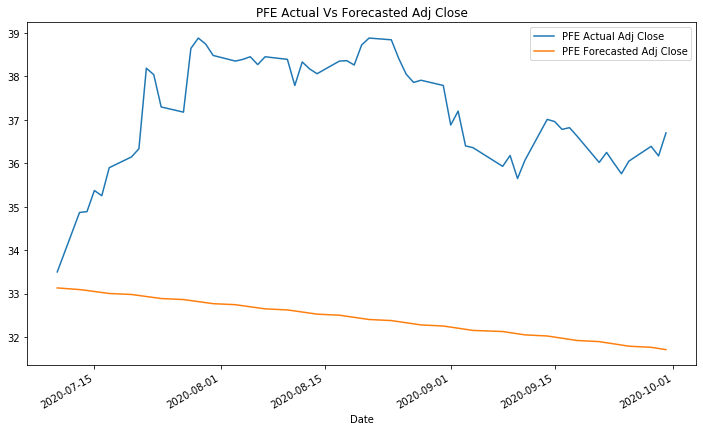

In [27]:
# Combining Date,Actual and Predicted Adj Closing price for GSK 
PFE_Comp1 = pd.DataFrame({'Date': pfe_df_val.index.values, 'PFE_Actual_Adj_Close': pfe_actual_val, 'PFE_Forecasted_Adj_Close': pfe_forecasted_values}, columns=['Date', 'PFE_Actual_Adj_Close', 'PFE_Forecasted_Adj_Close'])
PFE_Comp= PFE_Comp1.set_index("Date")

# Plot the variation of model
PFE_Comp["PFE_Actual_Adj_Close"].plot(label = 'PFE Actual Adj Close', figsize=(10,6),legend = True)
PFE_Comp["PFE_Forecasted_Adj_Close"].plot(label = 'PFE Forecasted Adj Close', title='PFE Actual Vs Forecasted Adj Close', figsize=(12,7),legend = True);
plt.savefig("../Images/TS_PFE_Actual_Forecasted.png")

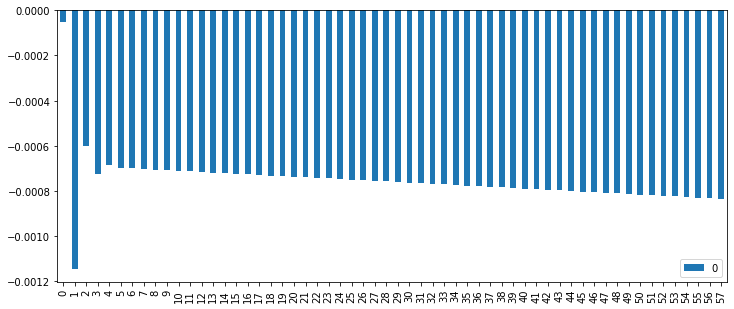

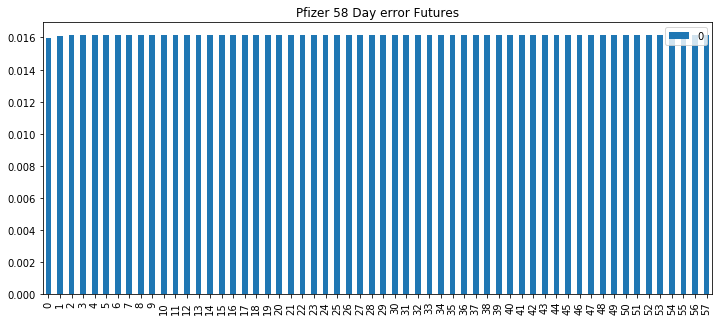

In [28]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=58)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=58)[1]).plot(kind='bar',title="Pfizer 58 Day error Futures",figsize=(12,5),legend = True);

# Forecasting AstraZeneca Returns using an ARIMA Model

In [29]:
model = ARIMA(AZN_returns['Adj Close'], order=(2, 1, 1))
# Fit the model
results = model.fit()
# save model
results.save("../Model Results/AZN_ARIMA_PC_model.pkl")
# load model
loaded = ARIMAResults.load("../Model Results/AZN_ARIMA_PC_model.pkl")
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Anirban\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Anirban\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid valu

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  632
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1707.698
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 01 Oct 2020   AIC                          -3405.397
Time:                        18:55:33   BIC                          -3383.152
Sample:                             1   HQIC                         -3396.758
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.284e-06   1.34e-05      0.171      0.864   -2.39e-05    2.85e-05
ar.L1.D.Adj Close    -0.1376      0.039     -3.532      0.000      -0.214      -0.061
ar.L2.D.Adj Close     0.0655      0.039      1.678      0.093      -0.011       0.142
ma.L1.D.Adj Close    -0.9795        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9964           +0.0000j            2.9964            0.5000
AR.2            5.0989           +0.0000j            5.0989            0.0000
MA.1            1.0209           +0.0000j            1.0209            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
# #Getting the forecasted values of the adjusted closing price
azn_forecasted_values=np.array(1+ results.forecast(steps=58)[0])
for i in range(1, len(azn_forecasted_values)):
    azn_forecasted_values[i] = azn_forecasted_values[i]*azn_forecasted_values[i-1]
azn_forecasted_values = azn_forecasted_values*azn_df.loc['2020-07-09']['Adj Close']
azn_forecasted_values

array([53.71493113, 53.77308161, 53.87297827, 53.95987221, 54.051594  ,
       54.14209183, 54.23337184, 54.32476102, 54.41648484, 54.50846895,
       54.60073939, 54.69328863, 54.78612039, 54.87923462, 54.97263255,
       55.06631499, 55.16028286, 55.2545371 , 55.3490786 , 55.4439083 ,
       55.53902713, 55.634436  , 55.73013587, 55.82612766, 55.92241231,
       56.01899077, 56.11586399, 56.21303291, 56.3104985 , 56.40826171,
       56.5063235 , 56.60468485, 56.70334672, 56.80231008, 56.90157592,
       57.00114521, 57.10101894, 57.2011981 , 57.30168369, 57.40247669,
       57.5035781 , 57.60498894, 57.70671022, 57.80874293, 57.91108811,
       58.01374677, 58.11671993, 58.22000862, 58.32361387, 58.42753673,
       58.53177822, 58.6363394 , 58.74122131, 58.846425  , 58.95195154,
       59.05780197, 59.16397737, 59.2704788 ])

   ### Validation of AstraZeneca

In [31]:
# Getting the array of the actual adjusted closing prices for GSK stock
azn_actual_val = np.array(azn_df_val["Adj Close"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(azn_actual_val) - np.array(azn_forecasted_values))
AZN_avg_error = sum(abs_change)/ len(abs_change)
# Printing the average error term
print(AZN_avg_error)

1.9478655000964213


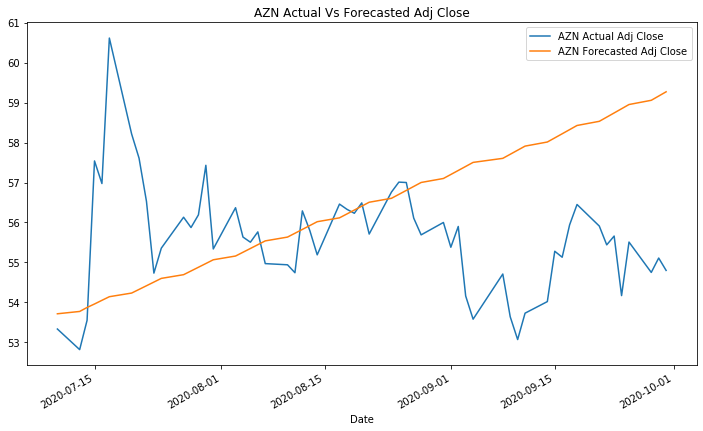

In [32]:
# Combining Date,Actual and Predicted Adj Closing price for GSK 
AZN_Comp1 = pd.DataFrame({'Date': azn_df_val.index.values, 'AZN_Actual_Adj_Close': azn_actual_val, 'AZN_Forecasted_Adj_Close': azn_forecasted_values}, columns=['Date', 'AZN_Actual_Adj_Close', 'AZN_Forecasted_Adj_Close'])
AZN_Comp= AZN_Comp1.set_index("Date")

# Plot the variation of model
AZN_Comp["AZN_Actual_Adj_Close"].plot(label = 'AZN Actual Adj Close', figsize=(10,6),legend = True)
AZN_Comp["AZN_Forecasted_Adj_Close"].plot(label = 'AZN Forecasted Adj Close', title='AZN Actual Vs Forecasted Adj Close', figsize=(12,7),legend = True);
plt.savefig("../Images/TS_AZN_GSK_Actual_Forecasted.png")

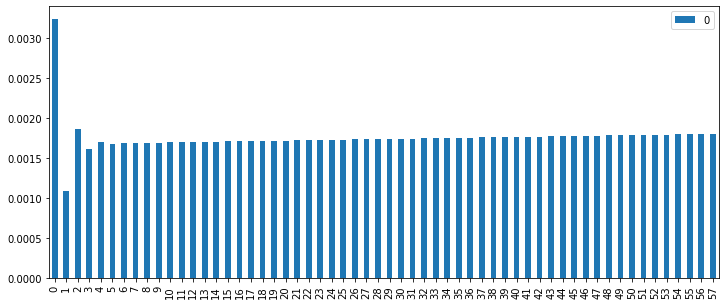

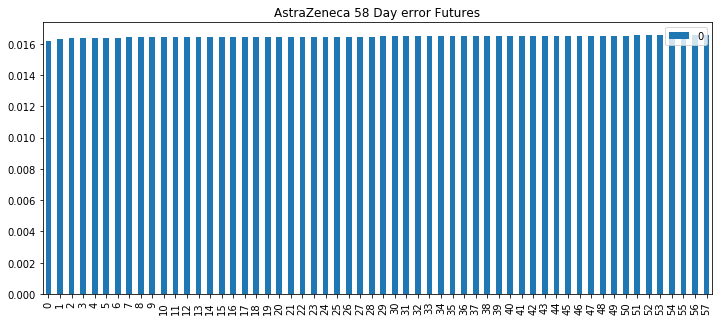

In [33]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=58)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=58)[1]).plot(kind='bar',title="AstraZeneca 58 Day error Futures",figsize=(12,5),legend = True);